# MNIST Neural Network Classifier (MLP)

This implementation uses a fully connected neural network (MLP) rather than a CNN to classify MNIST digits. This approach:
- Flattens the 28x28 images into 784-dimensional vectors
- Processes through fully connected layers
- Demonstrates core neural network concepts without convolutions

Key features:
- Custom MLP implementation with manual forward/backward propagation
- Comparison of different hyper-parameters and initializations
- Single example and batch processing implementations
- Cross-entropy loss from scratch

## Architecture Details

...

## Implementation Notes

This implementation intentionally uses an MLP instead of a CNN to:
- Demonstrate fundamental neural network concepts
- Show how images can be processed as flat vectors
- Provide a baseline for comparing against CNN implementations

In [80]:
# Imports

import torchvision
import torchvision.transforms as transforms
import torch
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time


In [17]:
# Load the MNIST dataset

transform = transforms.ToTensor()

batch_size = 128

trainset = torchvision.datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

print("trainset size:", len(trainset))
print("testset size:", len(testset))


trainset size: 60000
testset size: 10000


In [19]:
# Shape of an example

ex = trainset[0][0]
print(f"{ex.shape=}")


ex.shape=torch.Size([1, 28, 28])


In [20]:
# All labels in training set

classes = set([y for _, y in trainset])
classes


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [23]:
def show_imgs(imgs):
    """
    Show images in a row
    """
    imgs_data = [img for img, _ in imgs]
    imgs_label = [label for _, label in imgs]
    plt.figure(figsize=(10, 2))
    for i, img in enumerate(imgs_data):
        plt.subplot(1, len(imgs_data), i+1)
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return imgs_label


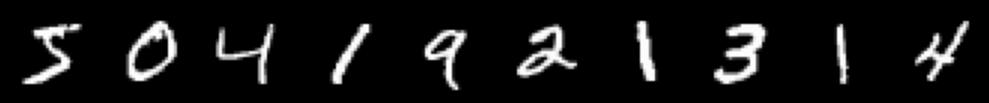

labels: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [24]:
sample_imgs = [trainset[i] for i in range(10)]
print(f"labels: {show_imgs(sample_imgs)}")


## MLP Classifier Implementation

This Multi-Layer Perceptron:
1. Flattens each 28x28 image into a 784-dimensional vector
2. Processes through a fully connected hidden layer with ReLU activation
3. Outputs probabilities for each digit (0-9) using softmax

Note: While CNNs are typically more effective for image tasks, this MLP implementation demonstrates core neural network principles and provides a useful baseline.

In [82]:
class MLPClassifier:
    def __init__(self, lr, input_dim=784, hidden_dim=128, output_dim=10, xavier_init=True):
        self.lr = lr
        self.init_type = 'xavier' if xavier_init else 'random'

        if xavier_init:
            # uniform Xavier init
            x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
            x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

            self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
            self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        else:
            # random init
            scale = 0.01
            self.W1 = torch.tensor(np.random.randn(hidden_dim, input_dim) * scale, requires_grad=True)
            self.W2 = torch.tensor(np.random.randn(output_dim, hidden_dim) * scale, requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, y_true):
        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, x):
        self.x = x
        return self.forward()


In [83]:
# Shape of single exanple
trainset[0][0].shape # requires reshaping to 784 features

x = torch.tensor(np.float64(trainset[0][0].reshape(784)))


In [84]:
# Dummy model (untrained)
dummy = MLPClassifier(0.001)
dummy(x)

dummy_out = dummy.forward() # outputs probabilities for each class
dummy_out_df = pd.DataFrame(dummy_out.detach().numpy(), columns=["Probability"])
dummy_out_df.index.name = "Class"
display(dummy_out_df)

print(f"actual: {trainset[0][1]}")
print(f"prediction: {torch.argmax(dummy_out).item()}")


,Probability
Class,
0,0.152464
1,0.092955
2,0.096981
3,0.092013
4,0.124922
5,0.103800
6,0.075570
7,0.095003
8,0.068590


actual: 5
prediction: 0


In [85]:
def cross_entropy(out, y):
    """
    Cross entropy loss: -sum(true_class_distribution * log(predicted_class_distribution))
    - y is the true class (scalar), requires one-hot encoding
        - ex. if y is 2 then y_ohe represents class probability distribution of 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
    """
    y_ohe = torch.zeros_like(out)
    y_ohe[y] = 1.0

    return np.float64(-torch.sum(y_ohe * torch.log(out +1e-10)))


In [86]:
def criterion(y_pred, y_true, loss_fn):
    """
    Compute loss for a single example
    """
    return loss_fn(y_pred, y_true)


In [87]:
# Test the loss functions

y_true = 5
y_pred1 = torch.tensor([0.2, 0.1, 0.2, 0.1, 0.1, 0.3, 0.1, 0.1, 0.1, 0.1])
y_pred2 = torch.tensor([0.0529, 0.0529, 0.0529, 0.0529, 0.0529, 0.5238, 0.0529, 0.0529, 0.0529,
        0.0529])

print(f"Cross-entropy loss between {y_true} and y_pred1:", criterion(y_pred1, y_true, cross_entropy))
print(f"Cross-entropy loss between {y_true} and y_pred2:", criterion(y_pred2, y_true, cross_entropy))


Cross-entropy loss between 5 and y_pred1: 1.2039728164672852
Cross-entropy loss between 5 and y_pred2: 0.6466453075408936


In [126]:
LEARNING_RATE = 0.001
EPOCHS = 5
experiment_results = {
    f'random_init_lr{LEARNING_RATE}_e{EPOCHS}': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    },
    f'xavier_init_lr{LEARNING_RATE}_e{EPOCHS}': {
        'train_losses': [],
        'test_losses': [],
        'train_accuracy': 0,
        'test_accuracy': 0,
        'epoch_times': [],
        'loss_metrics': {
            'mean_train_loss': 0,
            'variance_train_loss': 0,
        },
    }
}


In [127]:
random_init_model = MLPClassifier(LEARNING_RATE, xavier_init=False)
xavier_init_model = MLPClassifier(LEARNING_RATE, xavier_init=True)

for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Training model with {init_type} initialization")
    for epoch in range(EPOCHS):
        start = time.time()
        epoch_loss = 0
    
        for i in range(len(trainset)):
            img, label = trainset[i]
            x = torch.tensor(np.float64(img.reshape(784)))
    
            output = model(x)
    
            loss = criterion(output, label, cross_entropy)
            epoch_loss += loss
            
            model.backward(label)
            
            if i % 1000 == 0:
                print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i}/{len(trainset)}], Loss: {loss:.4f}')
        end = time.time()
        delta = end - start
        avg_loss = epoch_loss / len(trainset)
        experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_losses'].append(avg_loss)
        experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['epoch_times'].append(delta)
        print(f'Epoch [{epoch+1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')


Training model with random initialization
Epoch [1/5], Step [0/60000], Loss: 2.3124
Epoch [1/5], Step [1000/60000], Loss: 2.2862
Epoch [1/5], Step [2000/60000], Loss: 2.3368
Epoch [1/5], Step [3000/60000], Loss: 2.3013
Epoch [1/5], Step [4000/60000], Loss: 2.0644
Epoch [1/5], Step [5000/60000], Loss: 1.8277
Epoch [1/5], Step [6000/60000], Loss: 1.3788
Epoch [1/5], Step [7000/60000], Loss: 1.7516
Epoch [1/5], Step [8000/60000], Loss: 0.1613
Epoch [1/5], Step [9000/60000], Loss: 0.7788
Epoch [1/5], Step [10000/60000], Loss: 0.3105
Epoch [1/5], Step [11000/60000], Loss: 0.1337
Epoch [1/5], Step [12000/60000], Loss: 0.3280
Epoch [1/5], Step [13000/60000], Loss: 0.6129
Epoch [1/5], Step [14000/60000], Loss: 0.1522
Epoch [1/5], Step [15000/60000], Loss: 1.0078
Epoch [1/5], Step [16000/60000], Loss: 0.0942
Epoch [1/5], Step [17000/60000], Loss: 0.5162
Epoch [1/5], Step [18000/60000], Loss: 0.2893
Epoch [1/5], Step [19000/60000], Loss: 0.3947
Epoch [1/5], Step [20000/60000], Loss: 0.0512
Epoch

In [128]:
# Calculate mean and variance of losses

for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    model_name = f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}'
    n = len(experiment_results[model_name]['train_losses'])
    all_losses = experiment_results[model_name]['train_losses']
    mean = sum(all_losses) / n

    var = sum((x - mean) ** 2 for x in all_losses) / n
    experiment_results[model_name]['loss_metrics']['mean_train_loss'] = mean
    experiment_results[model_name]['loss_metrics']['variance_train_loss'] = var

    print(f"{model_name} mean loss: {mean:.4f}, variance loss: {var:.4f}")


random_init_lr0.001_e5 mean loss: 0.3094, variance loss: 0.0324
xavier_init_lr0.001_e5 mean loss: 0.2594, variance loss: 0.0161


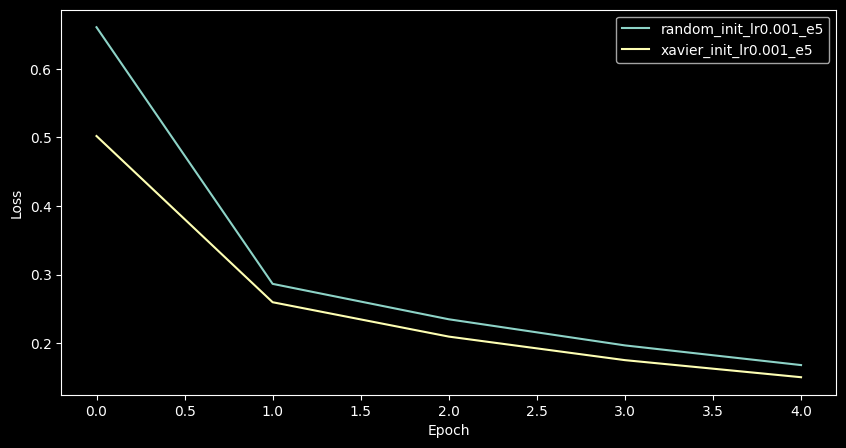

In [129]:
def plot_losses(losses):
    """
    Plot losses for each model
    """
    plt.figure(figsize=(10, 5))
    for model_name, loss in losses.items():
        plt.plot(loss, label=model_name)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_losses({k: v['train_losses'] for k, v in experiment_results.items()})


In [130]:
for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Testing model on train with {init_type} initialization")

    train_loss = 0
    correct = 0

    for i in range(len(trainset)):
        img, label = trainset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = model(x)
        loss = criterion(output, label, cross_entropy)
        train_loss += loss

        pred = torch.argmax(output)
        correct += (pred == label).item()

        if i % 1000 == 0:
            print(f'Step [{i}/{len(trainset)}], Loss: {loss:.4f}')

    avg_train_loss = train_loss / len(trainset)
    accuracy = 100 * correct / len(trainset)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_losses'].append(avg_train_loss)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['train_accuracy'] = accuracy

    print(f'{avg_train_loss=:.4f}, {accuracy=:.2f}%')


Testing model on train with random initialization
Step [0/60000], Loss: 0.0178
Step [1000/60000], Loss: 0.0202
Step [2000/60000], Loss: 0.2207
Step [3000/60000], Loss: 0.0532
Step [4000/60000], Loss: 0.0035
Step [5000/60000], Loss: 0.2901
Step [6000/60000], Loss: 0.0030
Step [7000/60000], Loss: 0.3763
Step [8000/60000], Loss: 0.0000
Step [9000/60000], Loss: 0.0021
Step [10000/60000], Loss: 0.0005
Step [11000/60000], Loss: 0.0005
Step [12000/60000], Loss: 0.0334
Step [13000/60000], Loss: 0.0428
Step [14000/60000], Loss: 0.0018
Step [15000/60000], Loss: 0.0134
Step [16000/60000], Loss: 0.0001
Step [17000/60000], Loss: 0.0052
Step [18000/60000], Loss: 0.0671
Step [19000/60000], Loss: 0.0029
Step [20000/60000], Loss: 0.0003
Step [21000/60000], Loss: 0.4326
Step [22000/60000], Loss: 0.1318
Step [23000/60000], Loss: 0.0005
Step [24000/60000], Loss: 0.0028
Step [25000/60000], Loss: 0.2792
Step [26000/60000], Loss: 0.0628
Step [27000/60000], Loss: 0.4007
Step [28000/60000], Loss: 0.0067
Step [

In [133]:
for model in [random_init_model, xavier_init_model]:
    init_type = model.init_type
    print(f"Testing model on test with {init_type} initialization")

    test_loss = 0
    correct = 0

    for i in range(len(testset)):
        img, label = testset[i]
        x = torch.tensor(np.float64(img.reshape(784)))

        output = model(x)
        loss = criterion(output, label, cross_entropy)
        test_loss += loss

        pred = torch.argmax(output)
        correct += (pred == label).item()

        if i % 1000 == 0:
            print(f'Step [{i}/{len(testset)}], Loss: {loss:.4f}')

    avg_test_loss = test_loss / len(testset)
    accuracy = 100 * correct / len(testset)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['test_losses'].append(avg_test_loss)
    experiment_results[f'{init_type}_init_lr{LEARNING_RATE}_e{EPOCHS}']['test_accuracy'] = accuracy

    print(f'{avg_test_loss=:.4f}, {accuracy=:.2f}%')


Testing model on test with random initialization
Step [0/10000], Loss: 0.0027
Step [1000/10000], Loss: 0.0271
Step [2000/10000], Loss: 0.0253
Step [3000/10000], Loss: 0.0330
Step [4000/10000], Loss: 1.0878
Step [5000/10000], Loss: 0.1115
Step [6000/10000], Loss: 0.0954
Step [7000/10000], Loss: 0.0078
Step [8000/10000], Loss: 0.0001
Step [9000/10000], Loss: 0.0022
avg_test_loss=0.1599, accuracy=95.19%
Testing model on test with xavier initialization
Step [0/10000], Loss: 0.0024
Step [1000/10000], Loss: 0.0416
Step [2000/10000], Loss: 0.0186
Step [3000/10000], Loss: 0.0480
Step [4000/10000], Loss: 1.0376
Step [5000/10000], Loss: 0.0330
Step [6000/10000], Loss: 0.0801
Step [7000/10000], Loss: 0.0057
Step [8000/10000], Loss: 0.0000
Step [9000/10000], Loss: 0.0005
avg_test_loss=0.1451, accuracy=95.68%


In [141]:
results = {}

for k, v in experiment_results.items():
    results[k] = {
        'train_accuracy': v['train_accuracy'],
        'test_accuracy': v['test_accuracy'],
    }

results_df = pd.DataFrame(results)
results_df


,random_init_lr0.001_e5,xavier_init_lr0.001_e5
train_accuracy,95.458333,95.953333
test_accuracy,95.190000,95.680000


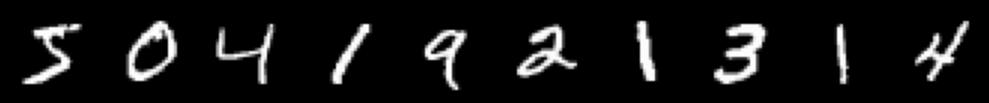

,actual,predicted
0,5,5
1,0,0
2,4,4
3,1,1
4,9,9
5,2,2
6,1,1
7,3,3
8,1,1
9,4,4


In [154]:
# Let's use the original sample images
show_imgs(sample_imgs)

pred = {
    "actual": [y for _, y in sample_imgs],
    "predicted": [torch.argmax(xavier_init_model(torch.tensor(np.float64(img.reshape(784))))).item() for img, _ in sample_imgs]
}
pred_df = pd.DataFrame(pred)
pred_df


In [ ]:
class BatchBLPClassifier:
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, lr=0.0001):
        self.lr = lr
        # uniform Xavier init
        x_min = -np.sqrt(6.0 / (input_dim + hidden_dim))
        x_max = np.sqrt(6.0 / (input_dim + hidden_dim))

        self.W1 = torch.tensor(np.random.uniform(x_min, x_max, (hidden_dim, input_dim)), requires_grad=True)
        self.W2 = torch.tensor(np.random.uniform(x_min, x_max, (output_dim, hidden_dim)), requires_grad=True)

        # internal biases for respective layers
        self.w1 = torch.zeros(hidden_dim, requires_grad=True)
        self.w2 = torch.zeros(output_dim, requires_grad=True)

        # prediction biases
        self.b1 = torch.zeros(hidden_dim, requires_grad=True)

    def forward(self):
        self.h1 = self.W1 @ self.x + self.w1
        self.y1 = torch.relu(self.h1) + self.b1
        self.h2 = self.W2 @ self.y1 + self.w2
        self.y2 = torch.softmax(self.h2, dim=0)
        return self.y2

    def backward(self, Y_true):
        batch_size = len(Y_true)

        # Compute gradients
        dy2 = self.y2.clone()
        dy2[y_true] -= 1
    
        # Gradients for second layer 
        dW2 = torch.outer(dy2, self.y1)
        dw2 = dy2
        
        # First layer gradients
        dy1 = self.W2.T @ dy2 
        dh1 = dy1 * (self.h1 > 0).float()  # ReLU derivative
        dW1 = torch.outer(dh1, self.x)
        dw1 = dh1
        db1 = dy1
    
        # Update weights
        with torch.no_grad():
            self.W2 -= self.lr * dW2
            self.w2 -= self.lr * dw2
            self.W1 -= self.lr * dW1
            self.w1 -= self.lr * dw1
            self.b1 -= self.lr * db1

    def __call__(self, X):
        self.X = X
        return self.forward(X)
